In [1]:
from string import punctuation

import numpy as np
from PIL import Image

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

['/device:GPU:0']

In [4]:
PATH_TO_DATA = '../../data/'

TEXT_FILES_DIR = PATH_TO_DATA + 'Flickr8k_text/'
IMAGES_DIR = PATH_TO_DATA + 'Flickr8k_Dataset/'

***

## Understanding and formating the data

In [5]:
with open(TEXT_FILES_DIR + 'Flickr8k.token.txt', 'r') as flickr8_token:
    raw_image_description = flickr8_token.read().split('\n')[:-1]

print('\n'.join(raw_image_description[:10]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [6]:
def get_dict_image_descriptions(raw_image_description):
    image_descriptions = dict()
    
    i = 0
    while i < len(raw_image_description):
        img_name = raw_image_description[i].split('.')[0]
        image_descriptions[img_name] = []
        
        while i < len(raw_image_description) and img_name == raw_image_description[i].split('.')[0]:
            descr = raw_image_description[i].split('\t')[1]
            image_descriptions[img_name].append(descr)
            i+=1
            
    return image_descriptions

image_descriptions = get_dict_image_descriptions(raw_image_description)

In [7]:
image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [8]:
def clean(sentence):
    # Tokenize
    tokens = sentence.split()
    
    # Lower Case
    tokens = [token.lower() for token in tokens]
    
    # Remove punct
    for i in range(len(tokens)):
        tokens[i] = ''.join([ch for ch in tokens[i] if ch not in punctuation])
    
    # Remove hanging chars
    tokens = [token for token in tokens if len(token) > 1]
    
    # Remove tokens with digits in it
    tokens = [token for token in tokens if token.isalpha()]
    
    return ' '.join(tokens)

In [9]:
clean(
    'A HellO! How12 are yoU>??'
)

'hello are you'

In [10]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [11]:
image_descriptions['101654506_8eb26cfb60']

['brown and white dog is running through the snow',
 'dog is running in the snow',
 'dog running through snow',
 'white and brown dog is running through snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [12]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]
    
print('Original Vocabulary size: {}'.format(len(vocabulary)))

Original Vocabulary size: 8763


In [13]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [14]:
vocabulary.update('0')
vocabulary.update(['<SOS>'])
vocabulary.update(['<EOS>'])

### Sort the Vocabulary lexically

In [15]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [16]:
word2idx = dict([(list(vocabulary)[i], i) for i in range(len(vocabulary))])
idx2word = dict([(i, list(vocabulary)[i]) for i in range(len(vocabulary))])

In [17]:
word2idx['dog']

2223

In [18]:
idx2word[2223]

'dog'

***

## Max Description Length

In [19]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on busy sidewalk in front of group of men playing instruments"


In [70]:
max_description_length = len(longets_description.split())+2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 34


***

## Train/Dev/Test split

In [71]:
def load_set_images(filename):
    with open(filename, 'r') as f:
        img_names = f.read().split('\n')[:-1]
        
    img_names = [name.split('.')[0] for name in img_names]
    return img_names

In [72]:
train_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.trainImages.txt')
dev_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.devImages.txt')
test_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.testImages.txt')

print('Train size: {}'.format(len(train_images)))
print('Dec size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dec size: 1000
Test size: 1000


In [73]:
def init_image_descriptions_set(set_images):
    image_descriptions_set = dict()
    
    for img_name in set_images:
        image_descriptions_set[img_name] = []
        descriptions = image_descriptions[img_name]
        
        for descr in descriptions:
            image_descriptions_set[img_name].append(
                '<SOS> ' + descr + ' <EOS>'
            )
    
    return image_descriptions_set

In [74]:
train_image_descriptions = init_image_descriptions_set(train_images)
dev_image_descriptions = init_image_descriptions_set(dev_images)
test_image_descriptions = init_image_descriptions_set(test_images)

print('Train size: {}'.format(len(train_image_descriptions)))
print('Dec size: {}'.format(len(dev_image_descriptions)))
print('Test size: {}'.format(len(test_image_descriptions)))

Train size: 6000
Dec size: 1000
Test size: 1000


In [75]:
train_image_descriptions['2513260012_03d33305cf']

['<SOS> black dog is running after white dog in the snow <EOS>',
 '<SOS> black dog chasing brown dog through snow <EOS>',
 '<SOS> two dogs chase each other across the snowy ground <EOS>',
 '<SOS> two dogs play together in the snow <EOS>',
 '<SOS> two dogs running through low lying body of water <EOS>']

***

## Data Generator

In [76]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
def load_image(filename, target_size=(299, 299)) :
    img = Image.open(IMAGES_DIR+filename+'.jpg')
    img.load()
    img = img.resize(target_size)
    return np.asarray(img, dtype='int32')

Image shape: (299, 299, 3)


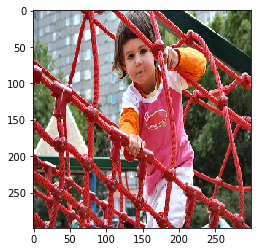

In [78]:
img = load_image('1007320043_627395c3d8')
print('Image shape: {}'.format(img.shape))

plt.imshow(img);

In [79]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(image_descriptions_set, word2idx, max_length, num_imgs_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while True:
        for img_id, desc_list in image_descriptions_set.items():
            img = load_image(img_id)
            n+=1
            
            for desc in desc_list:
                # encode the sequence
                seq = [word2idx[word] for word in desc.split() if word in word2idx]

                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(vocabulary))[0]
                    # store
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_imgs_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

***

In [80]:
from keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import Input, Embedding, Dropout, LSTM, Dense, Activation, Reshape, Add
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model



# Image Encoder (ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../../img/InceptionV3.png)

In [81]:
IMG_VECTOR_DIM = 256

In [104]:
img_in = Input((299, 299, 3), name='image_input')
    
# Get the InceptionV3 model trained on imagenet data
inceptionv3 = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
inceptionv3 = Model(inceptionv3.input, inceptionv3.layers[-2].output, name='inceptionv3')

# Do not alter the weights of the InceptionV3 model
for layer in inceptionv3.layers:
    layer.trainable = False
    
x = inceptionv3(img_in)
x = Dropout(0.5, name='dropout_encoder')(x)
x = Dense(IMG_VECTOR_DIM, name='dense_encoder')(x)
x = Activation('relu', name='relu_encoder')(x)
    
image_encoder = Model(img_in, x, name='image_encoder')

KeyboardInterrupt: 

In [83]:
# plot_model(image_encoder, to_file='image_encoder.png', show_shapes=True, show_layer_names=True)

print(image_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
inceptionv3 (Model)          (None, 2048)              21802784  
_________________________________________________________________
dropout_encoder (Dropout)    (None, 2048)              0         
_________________________________________________________________
dense_encoder (Dense)        (None, 256)               524544    
_________________________________________________________________
relu_encoder (Activation)    (None, 256)               0         
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________
None


***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../../img/LSTM.png)

### Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [84]:
GLOVE_200_DIR = PATH_TO_DATA + 'glove.6B/glove.6B.200d.txt'

def load_word_embedding_map(path_to_embeddings):
    word_embedding = dict()

    with open(GLOVE_200_DIR, encoding='utf-8') as f_embeddings:
        for line in f_embeddings:
            values = line.split()
            word_embedding[values[0]] = np.asarray(values[1:], dtype='float64')
    
    return word_embedding


# Load the Word Embeddings
word_embedding = load_word_embedding_map(GLOVE_200_DIR)

In [85]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [86]:
cosine_similarity(
    word_embedding['man'] - word_embedding['woman'],
    word_embedding['king'] - word_embedding['queen']
)

0.3936300348214125

#### Init the embedding matrix

In [87]:
def init_embedding_matrix(dim):
    embedding_matrix = np.zeros((len(vocabulary), dim))

    for word, idx in word2idx.items():
        try:
            embedding_matrix[idx, :] = word_embedding[word]
        except KeyError:
            pass
        
    return embedding_matrix

embedding_matrix = init_embedding_matrix(200)
print('Embedding Matrix shape: {}'.format(embedding_matrix.shape))

Embedding Matrix shape: (8766, 200)


## Build the Sequence Decoder

In [88]:
# Sequence Input
seq_in = Input((max_description_length,), name='sequence_input')


# GloVe embeddings
glove_embeddings = Embedding(
    len(vocabulary),
    200,
    input_length=max_description_length,
    mask_zero=True,
    name='glove_embeddings'
)
x = glove_embeddings(seq_in)
    
# Dropout
embeddings_dropout = Dropout(0.5, name='embeddings_dropout')
x = embeddings_dropout(x)

# Sequence Decoder
lstm_decoder = LSTM(IMG_VECTOR_DIM, name='lstm_decoder')
x = lstm_decoder(x)
    
sequence_decoder = Model(inputs=seq_in, outputs=x, name='sequence_decoder')
# Set GloVe weights
sequence_decoder.get_layer('glove_embeddings').set_weights([embedding_matrix])
sequence_decoder.get_layer('glove_embeddings').trainable = False


In [89]:
# plot_model(sequence_decoder, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  (None, 34)                0         
_________________________________________________________________
glove_embeddings (Embedding) (None, 34, 200)           1753200   
_________________________________________________________________
embeddings_dropout (Dropout) (None, 34, 200)           0         
_________________________________________________________________
lstm_decoder (LSTM)          (None, 256)               467968    
Total params: 2,221,168
Trainable params: 467,968
Non-trainable params: 1,753,200
_________________________________________________________________
None


***

# Model

In [90]:
encoder_vector = image_encoder(img_in)
seq_out = sequence_decoder(seq_in)

merger = Add(name='merger')
x = merger([encoder_vector, seq_out])

dense_decoder = Dense(IMG_VECTOR_DIM, name='dense_decoder')
x = dense_decoder(x)
relu_decoder = Activation('relu', name='relu_decoder')
x = relu_decoder(x)

dense_output = Dense(len(vocabulary), name='dense_output')
x = dense_output(x)
softmax_output = Activation('softmax', name='softmax_output')
x = softmax_output(x)

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=x, name='base_model')


### Visualize the model

In [91]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 34)           0                                            
__________________________________________________________________________________________________
image_encoder (Model)           (None, 256)          22327328    image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 256)          2221168     sequence_input[0][0]             
__________________________________________________________________________________________________
merger (Ad

***

# Inference


In [92]:
img_id = '1015118661_980735411b'

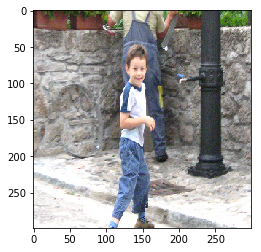

In [93]:
img = load_image(img_id)
plt.imshow(img);

In [94]:
image_descriptions[img_id]

['boy smiles in front of stony wall in city',
 'little boy is standing on the street while man in overalls is working on stone wall',
 'young boy runs aross the street',
 'young child is walking on stone paved street with metal pole and man behind him',
 'smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him']

In [95]:
img.shape

(299, 299, 3)

In [102]:
def greedy_search_inference(img_id):
    in_seq = '<SOS>'
    
    for i in range(max_description_length):
        sequence = [word2idx[w] for w in in_seq.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_description_length, padding='post')
        
        img = load_image(img_id)
        img = np.expand_dims(img, 0)
        yhat = model.predict([img, sequence], verbose=0)
#         return yhat
        yhat = np.argmax(yhat)

        word = idx2word[yhat]
        in_seq += ' ' + word
        
        print(in_seq)
        if word == '<EOS>':
            break

    final = in_seq.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [103]:
# 'subdivsion magnificant affectionately '

greedy_search_inference(img_id)

<SOS> banana
<SOS> banana banana
<SOS> banana banana banana
<SOS> banana banana banana banana
<SOS> banana banana banana banana banana
<SOS> banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana
<SOS> banana banana banana banana banana banana banana banana banana b

'banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana banana'

## Run Training

### Callbacks

In [171]:
reduce_lr = ReduceLROnPlateau()

filepath="weights/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=True, save_best_only=True, mode='max')

def on_epoch_end(val_loss, val_acc):
    img1_id = '1000268201_693b08cb0e'
    img2_id = '1002674143_1b742ab4b8'
    
    print(greedy_search_inference(img1_id))
    print(greedy_search_inference(img2_id))

lambda_callback = LambdaCallback(on_epoch_end=on_epoch_end)


callbacks = [reduce_lr, checkpoint, lambda_callback]

In [172]:
# model.load_weights('weights/weights-07-0.27.hdf5')

model.compile(RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [173]:
batch_size = 2
steps = len(truncated_map) // batch_size

model.fit_generator(
    data_generator(truncated_map, word2idx, max_description_length, batch_size),
    steps_per_epoch=steps,
    epochs=10000,
    verbose=True,
    callbacks=[lambda_callback],
#     validation_data=data_generator(truncated_map, word2idx, max_description_length, 2),
#     validation_steps=2,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
4/4 [==============================] - 11s 3s/step - loss: 7.5684 - acc: 0.0000e+00
wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing wearing
skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis skis
Epoch 2/10000
4/4 [==============================] - 0s 76ms/step - loss: 6.9776 - acc: 0.0000e+00
brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown
brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brown brow

KeyboardInterrupt: 

In [56]:
img_id = '2483993772_f64e9e4724'

img = load_image(img_id)

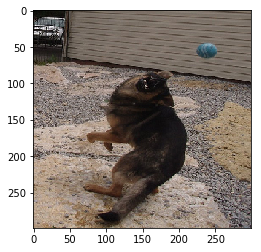

In [57]:
plt.imshow(img);

In [60]:
in_seq = '<SOS>'

sequence = [word2idx[w] for w in in_seq.split() if w in word2idx]
sequence = pad_sequences([sequence], maxlen=max_description_length)

In [65]:
' '.join(idx2word[a] for a in sequence[0])

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 <SOS>'

In [ ]:
model.predict([img, ])

In [ ]:
model.save_weights('./weights/model.h5')

In [ ]:
train_image_descriptions['1000268201_693b08cb0e']

In [ ]:
plt.imshow(load_image('1000268201_693b08cb0e'))

In [ ]:
greedy_search_inference('1000268201_693b08cb0e')